# **Bibliotecas e Funções**

In [1]:
%%capture

!pip install shap
!pip install optuna
!pip install cmaes

In [2]:
seed = 7
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Optuna
import optuna
from optuna.samplers import RandomSampler, TPESampler, CmaEsSampler
from optuna.visualization import plot_optimization_history

O arquivo 'functions_pred_cruzada' contém as funções que serão utilizadas para selecionar, pré-processar e treinar e validar os modelos de machine learning

In [3]:
!gdown 1uVoArwRTJmvbyFLyFniwFvWGHMfiNIWO --quiet

from functions_pred_cruzada import *

# **Dados**

In [6]:
%%capture

!gdown 194o9VVsCwcnt3Cp1oBbJdd0Sb_N2LOIF --quiet # Mais incidentes teste
!gdown 19BTOHjgR9mTjI8Sa8pl7M1dPJy5UmwDo --quiet # Mais incidentes treino

In [7]:
df_incid_treino = pd.read_csv('incid_treino.csv')
print(df_incid_treino.shape)
df_incid_treino.head(3)

(302582, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.900006,1.028664,-1.095067,-0.714301,0.958036,1.605010,-1.664088,-0.567847,0.737288,-0.078540,...,0.933829,0.327366,0.896330,-1.117133,0.396181,0.154944,0.964441,-0.475073,Colorretal,0
1,2.017011,0.078323,0.709472,1.270371,-0.915765,-1.584428,0.545300,1.015205,-1.536653,0.848079,...,-1.183185,-0.851058,-1.799187,0.743452,0.599581,-0.940442,-1.048322,-0.514970,Mama,1
2,0.474908,1.091681,-0.572151,1.167751,-0.344597,1.142798,0.315561,-0.242155,-0.156064,-0.038330,...,-1.672914,-0.765173,0.926783,-0.202185,0.393904,-0.406625,-0.776427,-0.218179,Pele,1


In [8]:
df_incid_teste = pd.read_csv('incid_teste.csv')
print(df_incid_teste.shape)
df_incid_teste.head(3)

(100864, 25)


,IDADE,SEXO,IBGE,CATEATEND,DIAGPREV,EC,CIRURGIA,RADIO,QUIMIO,HORMONIO,...,ANODIAG,DRS,RRAS,IBGEATEN,HABILIT2,ESCOLARI_preench,IBGE_idem_IBGEATEN,presenca_rec,TOPOGRUP,sobrevida_3anos
0,0.366829,-0.972134,1.141405,1.343451,0.958036,-0.047542,0.60093,-0.567847,0.737288,-0.078540,...,-1.734289,1.587885,0.660606,-1.716753,0.396181,1.180668,-1.036870,-0.475073,Colorretal,1
1,-0.166349,-0.972134,-0.649610,1.343451,0.958036,-0.873817,0.60093,1.761039,0.737288,-0.078540,...,-0.209650,1.767959,-0.282288,0.900562,-0.968850,0.154944,-1.036870,-0.475073,Colorretal,1
2,-0.623264,0.078323,-0.758504,1.270371,-0.915765,-1.584428,0.54530,1.015205,-1.536653,0.848079,...,-0.446767,-0.851058,-0.888302,0.743452,-0.803767,0.967430,-1.048322,-0.514970,Mama,1


In [9]:
# DFs de teste para cada tipo
colo_utero_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Colo de Útero']
colo_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Colorretal']
mama_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Mama']
pele_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Pele']
prost_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Próstata']
pulm_teste = df_incid_teste[df_incid_teste.TOPOGRUP == 'Pulmão']

colo_utero_teste.shape, colo_teste.shape, mama_teste.shape, pele_teste.shape, prost_teste.shape, pulm_teste.shape

((5368, 25), (14028, 25), (26133, 25), (25221, 25), (20862, 25), (9252, 25))

# **Mais incidentes Juntos**

## **Pré-processamento**

In [10]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_incid_treino['TOPOGRUP'] = oe.fit_transform(df_incid_treino[['TOPOGRUP']])
df_incid_teste['TOPOGRUP'] = oe.transform(df_incid_teste[['TOPOGRUP']])

ss = StandardScaler()
df_incid_treino['TOPOGRUP'] = ss.fit_transform(df_incid_treino[['TOPOGRUP']])
df_incid_teste['TOPOGRUP'] = ss.transform(df_incid_teste[['TOPOGRUP']])

In [11]:
# Dados pré-processados
list_drop = ['sobrevida_3anos']

# Treino
X_train = df_incid_treino.drop(columns=list_drop).copy()
y_train = df_incid_treino.sobrevida_3anos.copy()

# Teste
X_test = df_incid_teste.drop(columns=list_drop).copy()
y_test = df_incid_teste.sobrevida_3anos.copy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((302582, 24), (302582,), (100864, 24), (100864,))

In [12]:
feat_cols = X_train.columns
feat_cols

Index(['IDADE', 'SEXO', 'IBGE', 'CATEATEND', 'DIAGPREV', 'EC', 'CIRURGIA',
       'RADIO', 'QUIMIO', 'HORMONIO', 'TMO', 'IMUNO', 'OUTROS', 'CONSDIAG',
       'DIAGTRAT', 'ANODIAG', 'DRS', 'RRAS', 'IBGEATEN', 'HABILIT2',
       'ESCOLARI_preench', 'IBGE_idem_IBGEATEN', 'presenca_rec', 'TOPOGRUP'],
      dtype='object')

## **Treinamento e validação dos modelos de machine learning**

### **XGBoost**


#### **Modelo base**

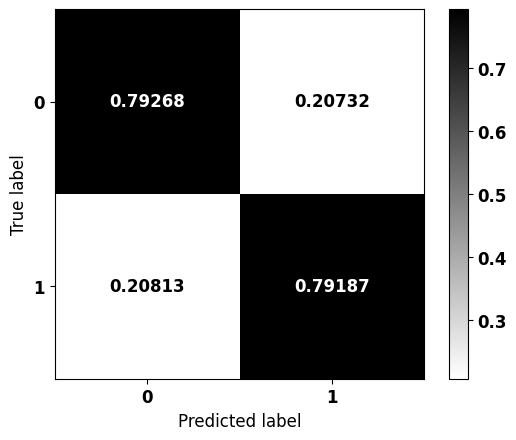


              precision    recall  f1-score   support

           0    0.62757   0.79268   0.70053     30938
           1    0.89619   0.79187   0.84080     69926

    accuracy                        0.79212    100864
   macro avg    0.76188   0.79227   0.77066    100864
weighted avg    0.81379   0.79212   0.79778    100864



In [13]:
# Criação e treinamento do modelo XGBoost
xgb = XGBClassifier(max_depth=7,
                    scale_pos_weight=0.368,
                    random_state=seed)

xgb.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(xgb, X_test, y_test)

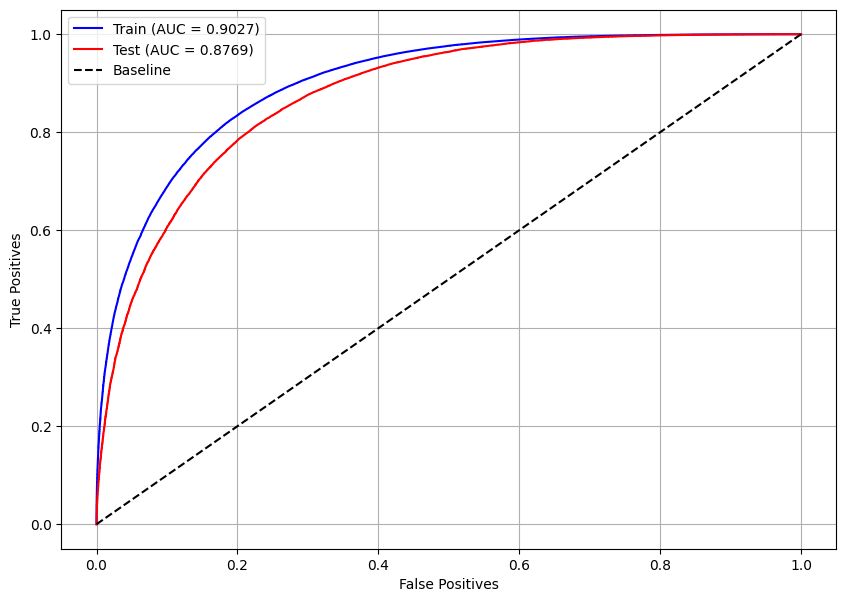

In [ ]:
# Curva ROC
plot_roc_curve(xgb, X_train, X_test, y_train, y_test)

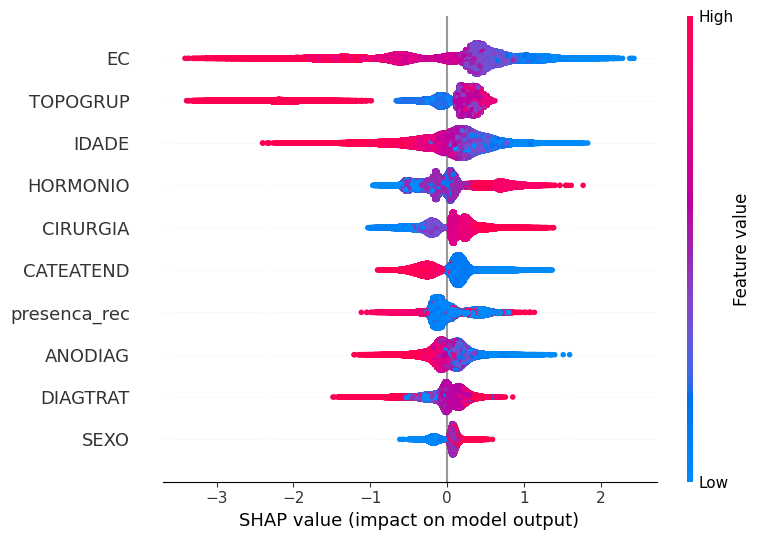

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = XGBClassifier(n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        gamma=gamma,
                        min_child_weight=min_child_weight,
                        colsample_bytree=colsample_bytree,
                        random_state=seed,
                        n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 136,
 'max_depth': 8,
 'learning_rate': 0.2,
 'gamma': 0.2,
 'min_child_weight': 6,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(0.355, 0.37, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

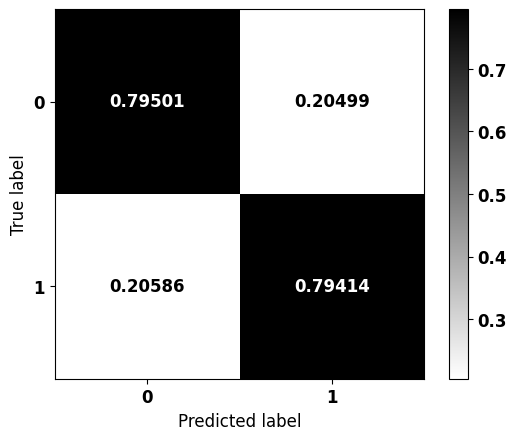


              precision    recall  f1-score   support

           0    0.63081   0.79501   0.70346     30938
           1    0.89750   0.79414   0.84266     69926

    accuracy                        0.79441    100864
   macro avg    0.76416   0.79457   0.77306    100864
weighted avg    0.81570   0.79441   0.79996    100864



In [15]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.3677

xgb_random = XGBClassifier()
xgb_random.set_params(**params)

xgb_random.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_random, X_test, y_test)

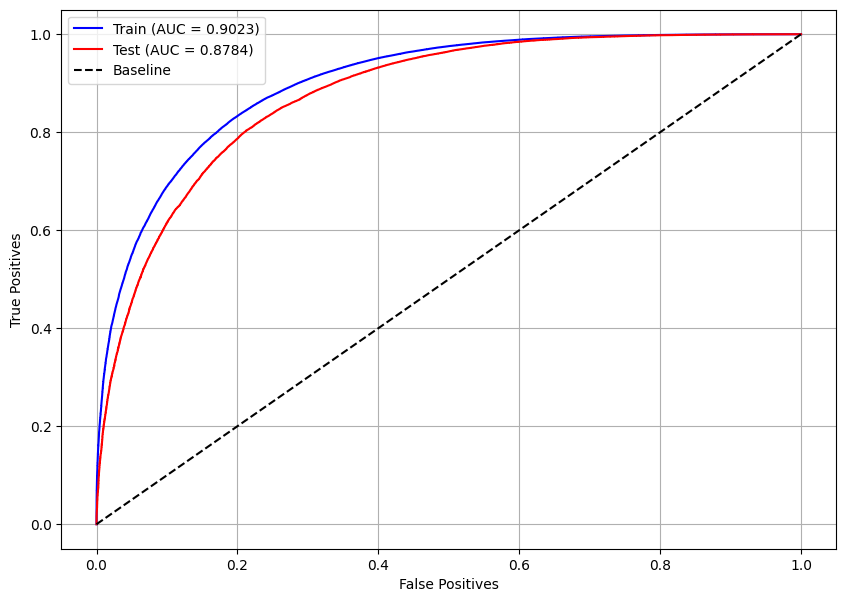

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_random, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 144,
 'max_depth': 8,
 'learning_rate': 0.15000000000000002,
 'gamma': 0.0,
 'min_child_weight': 3,
 'colsample_bytree': 0.4}

In [ ]:
pesos = np.round(np.arange(0.366, 0.37, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

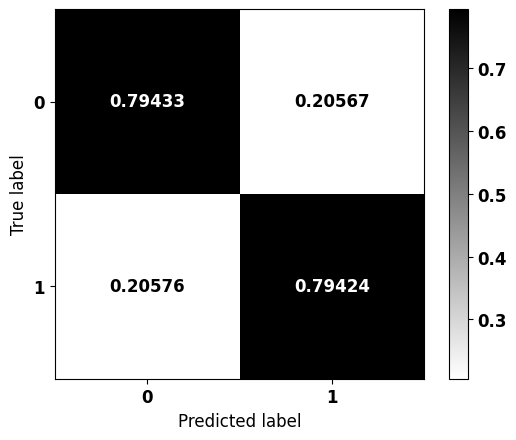


              precision    recall  f1-score   support

           0    0.63073   0.79433   0.70314     30938
           1    0.89721   0.79424   0.84259     69926

    accuracy                        0.79427    100864
   macro avg    0.76397   0.79429   0.77286    100864
weighted avg    0.81547   0.79427   0.79982    100864



In [17]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.3682

xgb_tpe = XGBClassifier()
xgb_tpe.set_params(**params)

xgb_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_tpe, X_test, y_test)

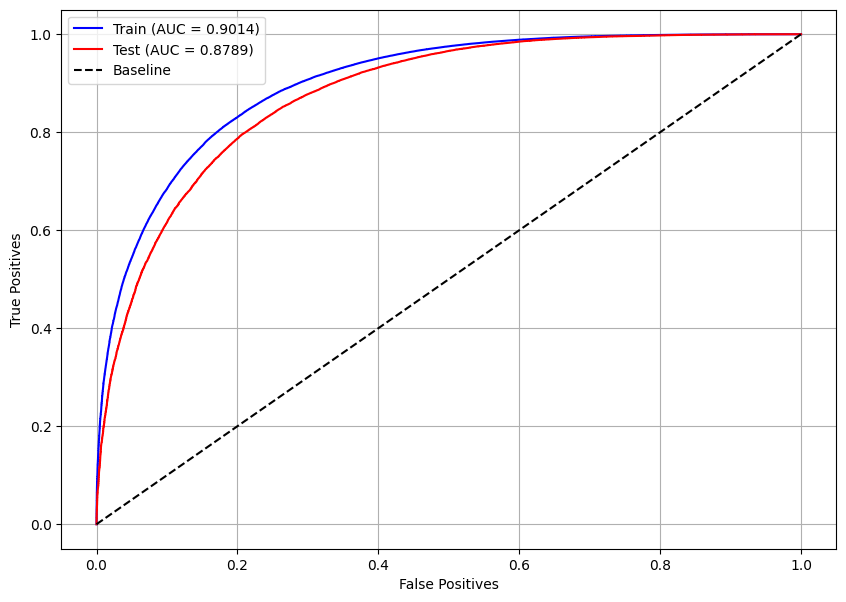

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyXGB = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyXGB.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyXGB.best_params

{'n_estimators': 125,
 'max_depth': 8,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'min_child_weight': 5,
 'colsample_bytree': 0.3}

In [ ]:
pesos = np.round(np.arange(0.366, 0.368, 0.0001), 4)
params = studyXGB.best_params
params['random_state'] = seed

for i in pesos:
    params['scale_pos_weight'] = i

    xgb_optuna = XGBClassifier()
    xgb_optuna.set_params(**params)

    xgb_optuna.fit(X_train, y_train)
    y_pred = xgb_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(xgb_optuna, X_test, y_test)
        print()

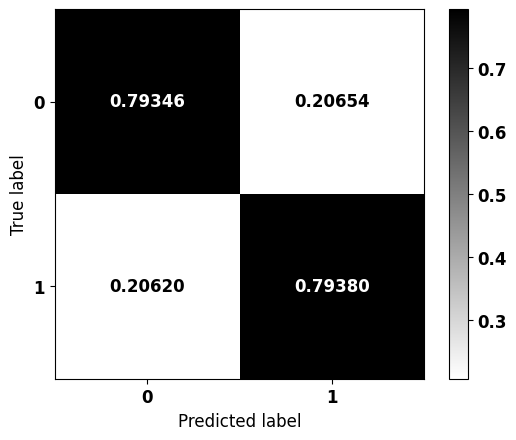


              precision    recall  f1-score   support

           0    0.62997   0.79346   0.70232     30938
           1    0.89676   0.79380   0.84214     69926

    accuracy                        0.79369    100864
   macro avg    0.76337   0.79363   0.77223    100864
weighted avg    0.81493   0.79369   0.79926    100864



In [19]:
# Modelo com os melhores parâmetros
params = studyXGB.best_params
params['random_state'] = seed
params['scale_pos_weight'] = 0.3671

xgb_cma = XGBClassifier()
xgb_cma.set_params(**params)

xgb_cma.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_cma, X_test, y_test)

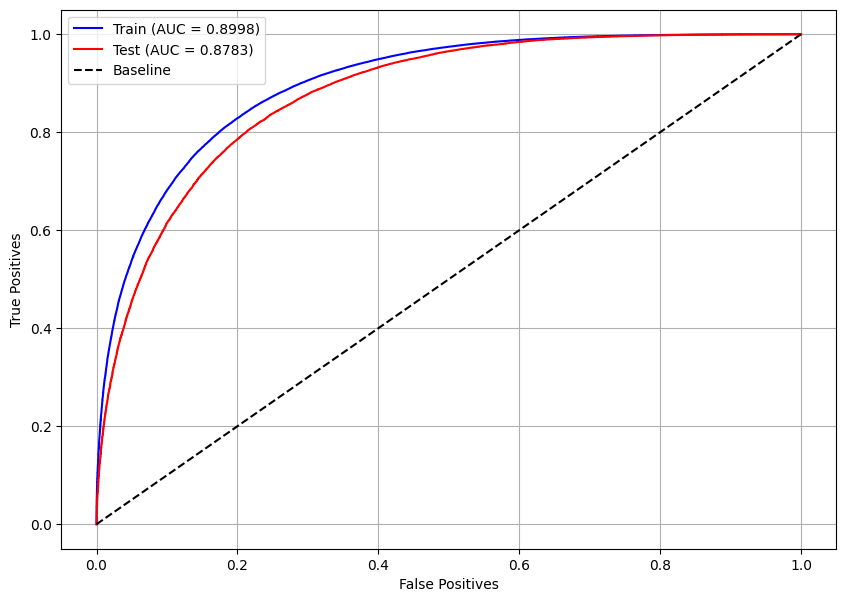

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [20]:
# Melhor modelo
models = [xgb_random, xgb_tpe, xgb_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=136, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


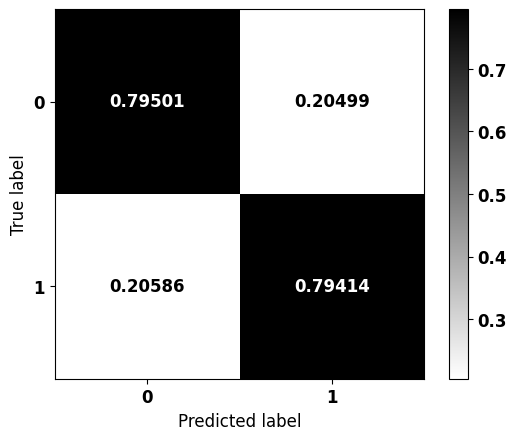


              precision    recall  f1-score   support

           0    0.63081   0.79501   0.70346     30938
           1    0.89750   0.79414   0.84266     69926

    accuracy                        0.79441    100864
   macro avg    0.76416   0.79457   0.77306    100864
weighted avg    0.81570   0.79441   0.79996    100864



In [21]:
params = best.get_params()

# Modelo com os melhores parâmetros
xgb_optuna = XGBClassifier()
xgb_optuna.set_params(**params)

xgb_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo XGBoost otimizado
plot_confusion_matrix(xgb_optuna, X_test, y_test)

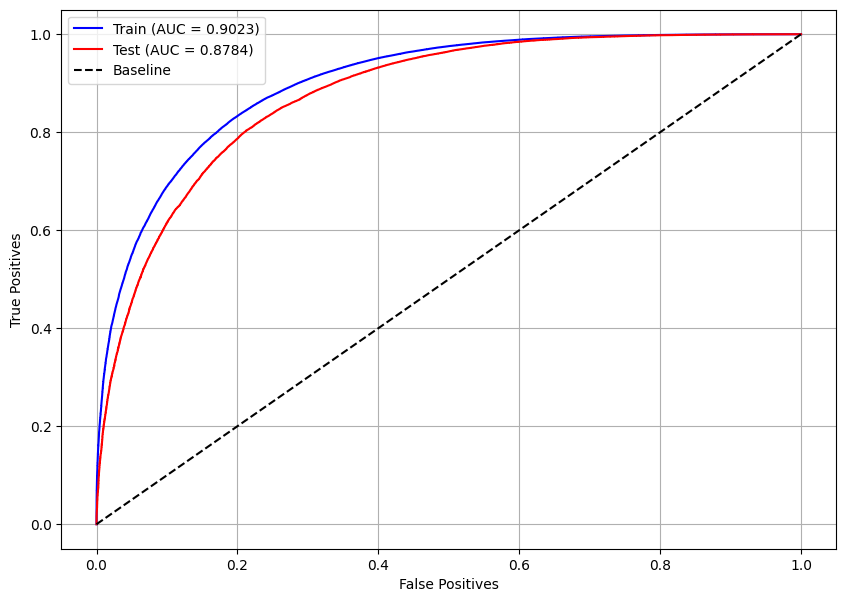

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(xgb_optuna, X_train, X_test, y_train, y_test)

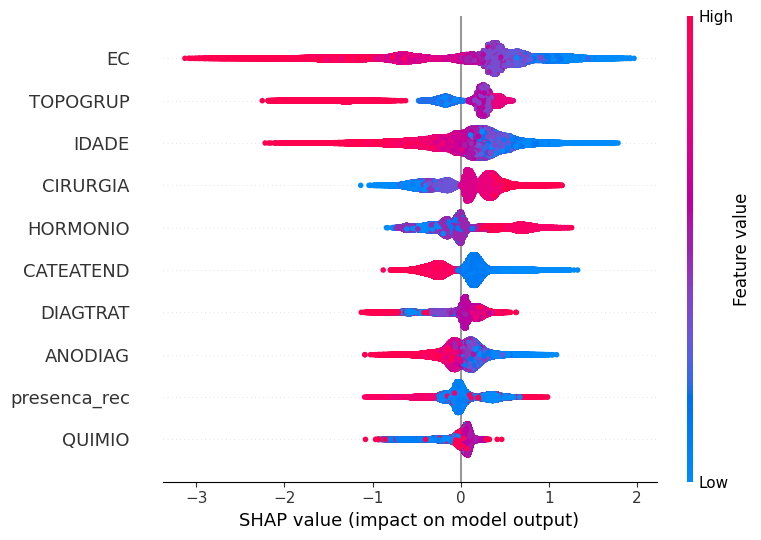

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(xgb_optuna, X_train, feat_cols)

### **LightGBM**


#### **Modelo base**

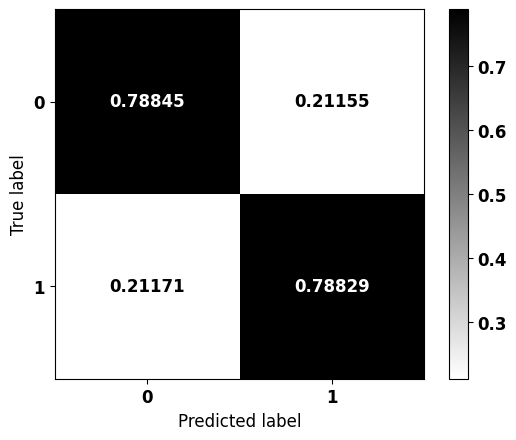


              precision    recall  f1-score   support

           0    0.62232   0.78845   0.69560     30938
           1    0.89387   0.78829   0.83776     69926

    accuracy                        0.78834    100864
   macro avg    0.75809   0.78837   0.76668    100864
weighted avg    0.81057   0.78834   0.79416    100864



In [22]:
# Criação e treinamento do modelo LightGBM
lgbm = LGBMClassifier(max_depth=10,
                      class_weight={0:2.585, 1:1},
                      random_state=seed,
                      verbose=-1)

lgbm.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(lgbm, X_test, y_test)

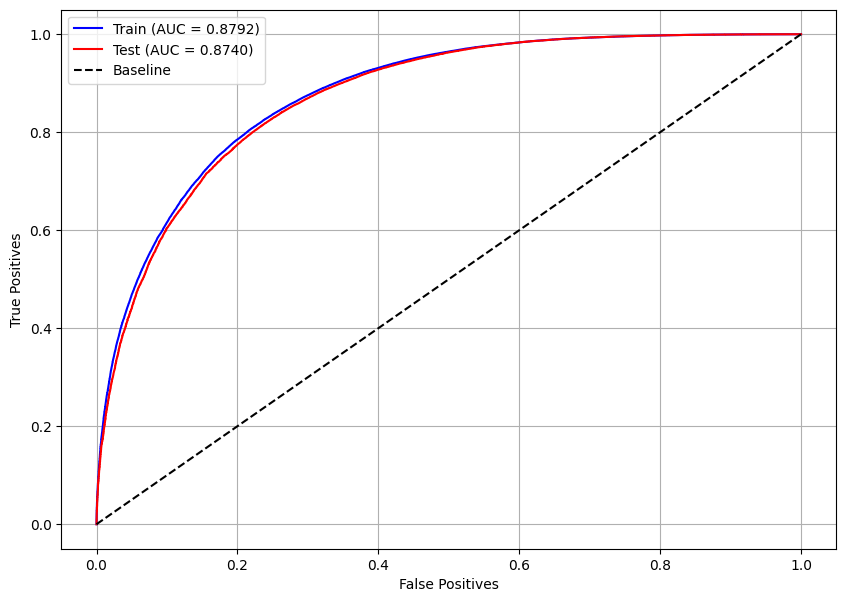

In [ ]:
# Curva ROC
plot_roc_curve(lgbm, X_train, X_test, y_train, y_test)

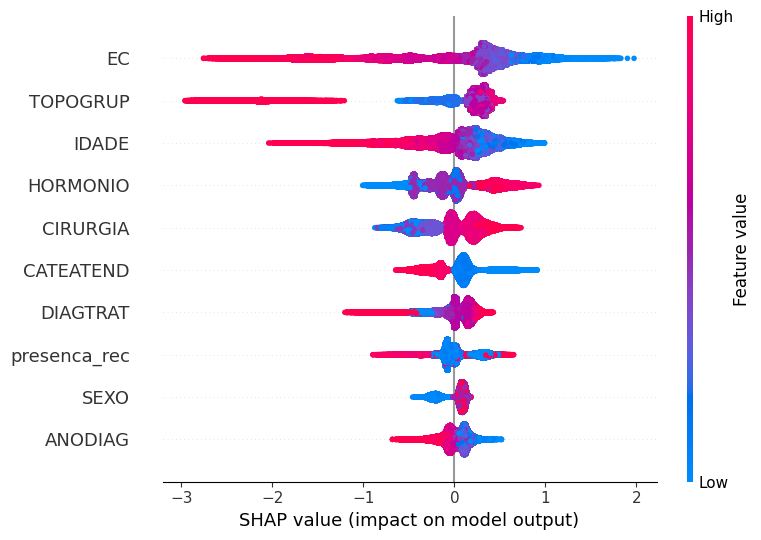

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm, X_train, feat_cols)

#### **Optuna**

In [ ]:
# Folds com a mesma proporção das classes
skf = StratifiedKFold(10, shuffle=True, random_state=seed)

# Função com o modelos e seus parâmetros, que terá sua métrica maximizada
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.01)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    cls = LGBMClassifier(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         colsample_bytree=colsample_bytree,
                         random_state=seed,
                         verbose=-1,
                         n_jobs=-1)

    return cross_val_score(cls, X_train, y_train,
                           cv=skf, scoring='accuracy').mean()

RandomSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=RandomSampler(seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 130,
 'max_depth': 7,
 'learning_rate': 0.18,
 'min_child_weight': 5,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(2.63, 2.66, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

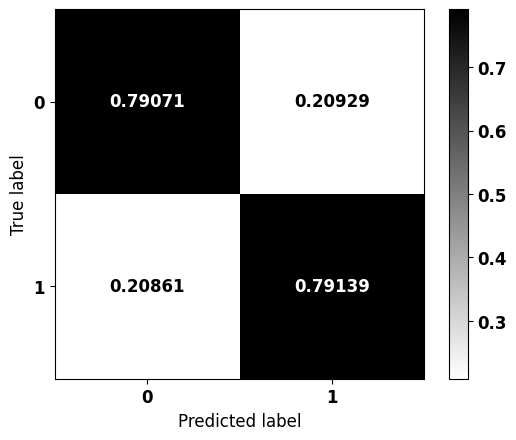


              precision    recall  f1-score   support

           0    0.62645   0.79071   0.69906     30938
           1    0.89525   0.79139   0.84012     69926

    accuracy                        0.79118    100864
   macro avg    0.76085   0.79105   0.76959    100864
weighted avg    0.81280   0.79118   0.79686    100864



In [24]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.64, 1:1}

lgbm_random = LGBMClassifier(verbose=-1)
lgbm_random.set_params(**params)

lgbm_random.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_random, X_test, y_test)

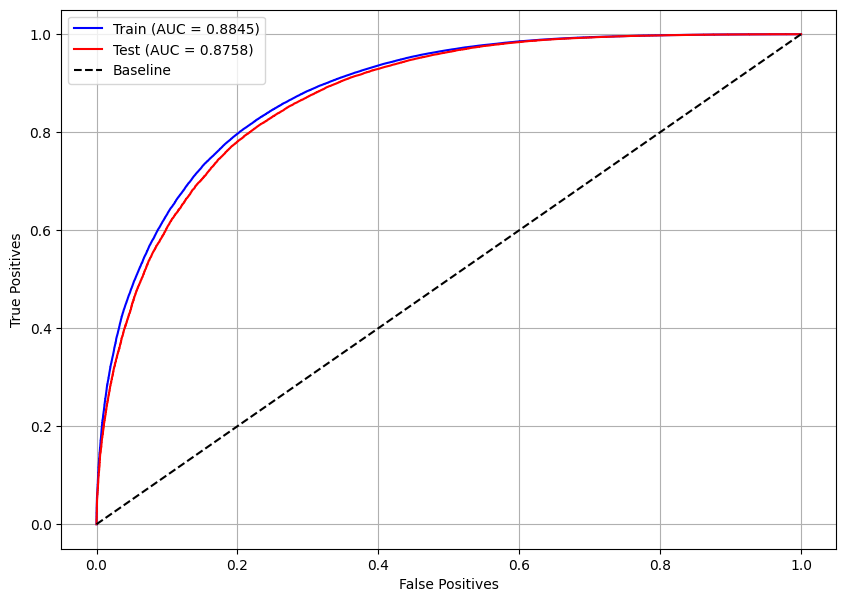

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_random, X_train, X_test, y_train, y_test)

TPESampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 149,
 'max_depth': 8,
 'learning_rate': 0.2,
 'min_child_weight': 5,
 'colsample_bytree': 0.6000000000000001}

In [ ]:
pesos = np.round(np.arange(2.64, 2.665, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

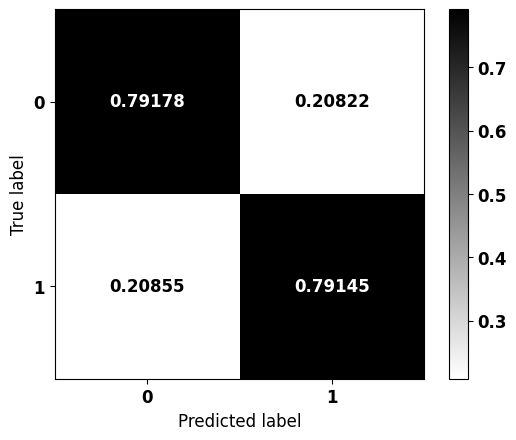


              precision    recall  f1-score   support

           0    0.62683   0.79178   0.69972     30938
           1    0.89574   0.79145   0.84037     69926

    accuracy                        0.79155    100864
   macro avg    0.76128   0.79161   0.77004    100864
weighted avg    0.81325   0.79155   0.79723    100864



In [26]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.645, 1:1}

lgbm_tpe = LGBMClassifier(verbose=-1)
lgbm_tpe.set_params(**params)

lgbm_tpe.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_tpe, X_test, y_test)

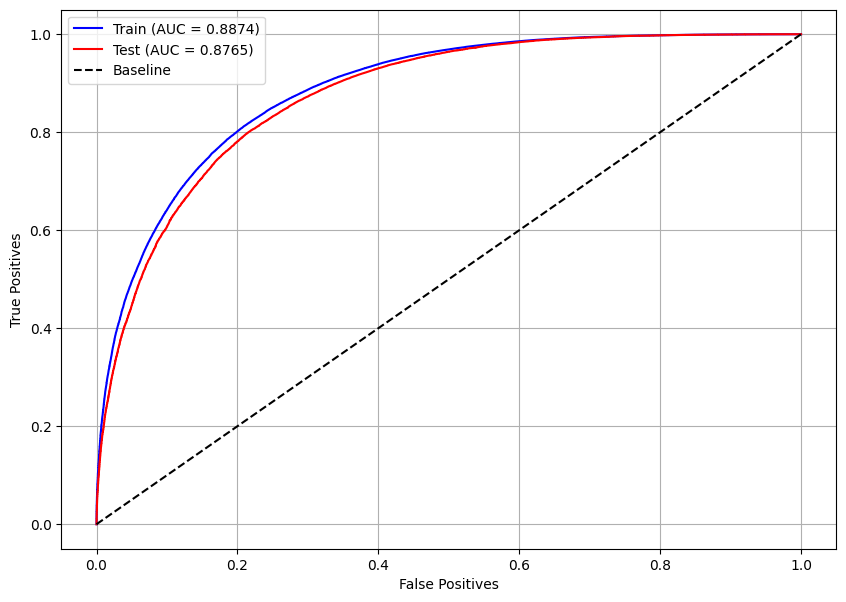

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_tpe, X_train, X_test, y_train, y_test)

CmaEsSampler

In [ ]:
# Criação do estudo e procura pelos hiperparâmetros
studyLGBM = optuna.create_study(direction='maximize', sampler=CmaEsSampler(seed=seed))
studyLGBM.optimize(objective, n_trials=100, n_jobs=-1)

In [ ]:
# Melhores parâmetros
studyLGBM.best_params

{'n_estimators': 150,
 'max_depth': 9,
 'learning_rate': 0.19,
 'min_child_weight': 7,
 'colsample_bytree': 0.7}

In [ ]:
pesos = np.round(np.arange(2.64, 2.665, 0.001), 3)
params = studyLGBM.best_params
params['random_state'] = seed

for i in pesos:
    params['class_weight'] = {0:i, 1:1}

    lgbm_optuna = LGBMClassifier(verbose=-1)
    lgbm_optuna.set_params(**params)

    lgbm_optuna.fit(X_train, y_train)
    y_pred = lgbm_optuna.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred, normalize='true').ravel()
    if abs(tn - tp) <= 0.001:

        print(i)
        plot_confusion_matrix(lgbm_optuna, X_test, y_test)
        print()

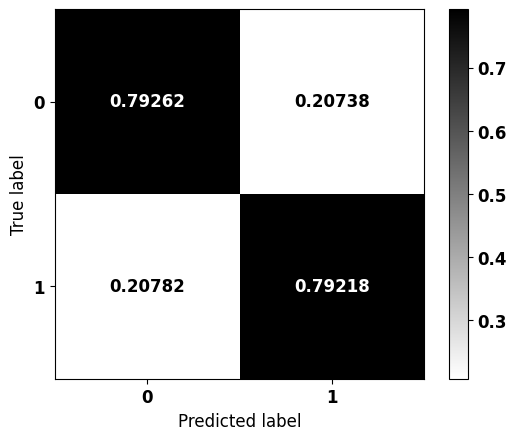


              precision    recall  f1-score   support

           0    0.62790   0.79262   0.70071     30938
           1    0.89620   0.79218   0.84099     69926

    accuracy                        0.79231    100864
   macro avg    0.76205   0.79240   0.77085    100864
weighted avg    0.81390   0.79231   0.79796    100864



In [28]:
# Modelo com os melhores parâmetros
params = studyLGBM.best_params
params['random_state'] = seed
params['class_weight'] = {0:2.659, 1:1}

lgbm_cma = LGBMClassifier(verbose=-1)
lgbm_cma.set_params(**params)

lgbm_cma.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_cma, X_test, y_test)

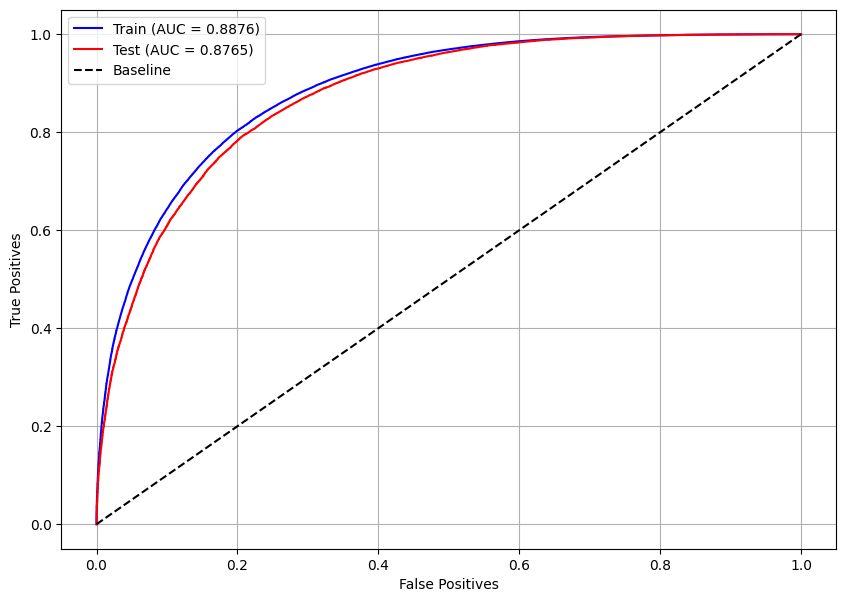

In [ ]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_cma, X_train, X_test, y_train, y_test)

**Modelo Otimizado**

In [29]:
# Melhor modelo
models = [lgbm_random, lgbm_tpe, lgbm_cma]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

LGBMClassifier(class_weight={0: 2.659, 1: 1}, colsample_bytree=0.7,
               learning_rate=0.19, max_depth=9, min_child_weight=7,
               n_estimators=150, random_state=7, verbose=-1)


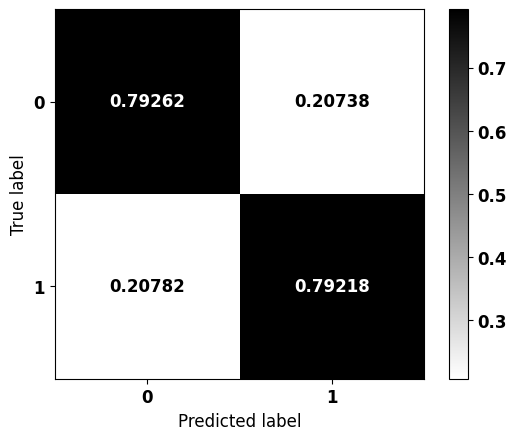


              precision    recall  f1-score   support

           0    0.62790   0.79262   0.70071     30938
           1    0.89620   0.79218   0.84099     69926

    accuracy                        0.79231    100864
   macro avg    0.76205   0.79240   0.77085    100864
weighted avg    0.81390   0.79231   0.79796    100864



In [30]:
# Modelo com os melhores parâmetros
params = best.get_params()

lgbm_optuna = LGBMClassifier(verbose=-1)
lgbm_optuna.set_params(**params)

lgbm_optuna.fit(X_train, y_train)

# Matriz de confusão do modelo LightGBM otimizado
plot_confusion_matrix(lgbm_optuna, X_test, y_test)

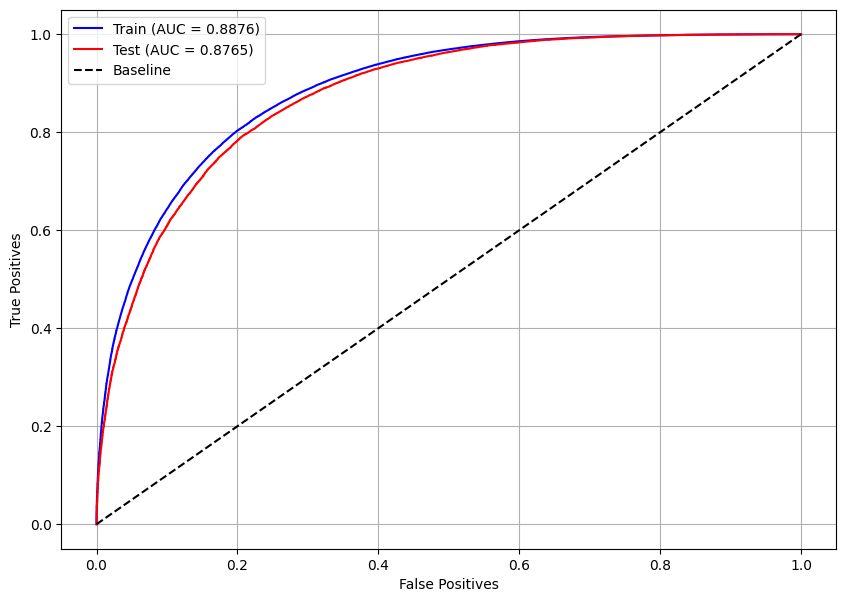

In [31]:
# Curva ROC do modelo otimizado
plot_roc_curve(lgbm_optuna, X_train, X_test, y_train, y_test)

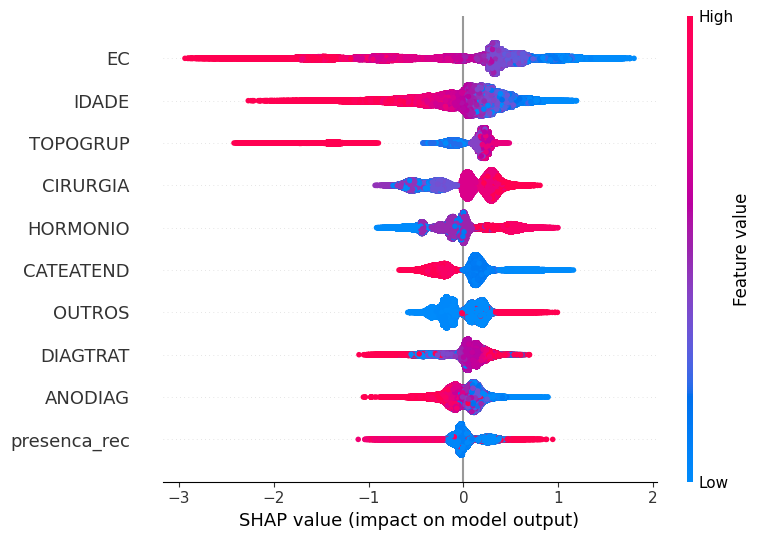

In [ ]:
# Importância das features pelos valores SHAP
plot_shap_values(lgbm_optuna, X_train, feat_cols)

## **Testes cruzados**

In [32]:
# Melhor modelo
models = [xgb, xgb_optuna, lgbm, lgbm_optuna]
for i, m in enumerate(models):
    if i == 0:
        best = m
    else:
        best_score = best.score(X_test, y_test)
        score = m.score(X_test, y_test)
        if score > best_score:
            best = m

print(best)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=136, n_jobs=None,
              num_parallel_tree=None, random_state=7, ...)


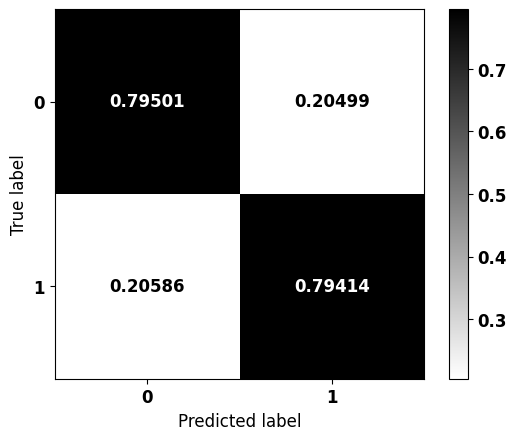


              precision    recall  f1-score   support

           0    0.63081   0.79501   0.70346     30938
           1    0.89750   0.79414   0.84266     69926

    accuracy                        0.79441    100864
   macro avg    0.76416   0.79457   0.77306    100864
weighted avg    0.81570   0.79441   0.79996    100864



In [33]:
plot_confusion_matrix(best, X_test, y_test)

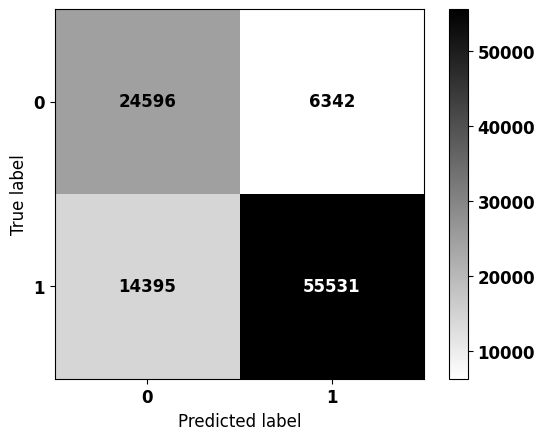


              precision    recall  f1-score   support

           0    0.63081   0.79501   0.70346     30938
           1    0.89750   0.79414   0.84266     69926

    accuracy                        0.79441    100864
   macro avg    0.76416   0.79457   0.77306    100864
weighted avg    0.81570   0.79441   0.79996    100864



In [34]:
plot_confusion_matrix(best, X_test, y_test, norm=False)

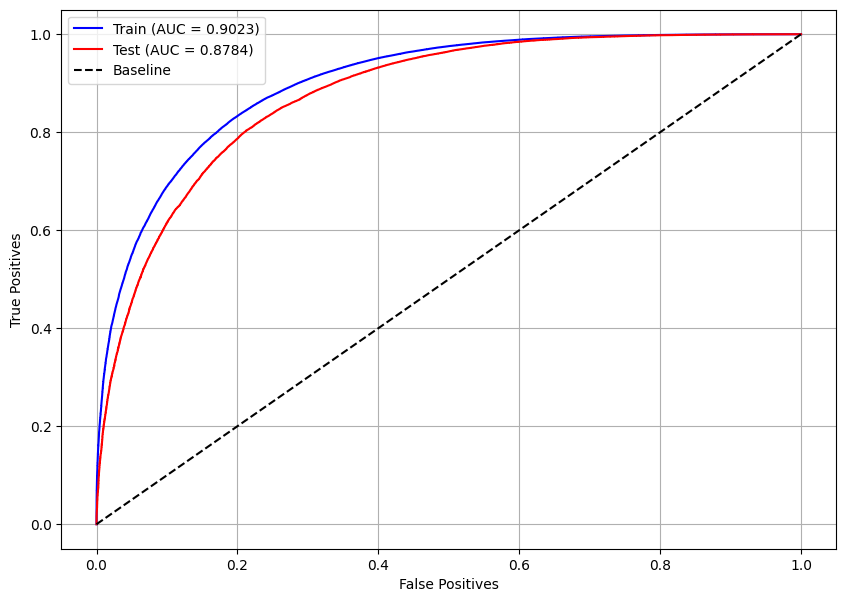

In [35]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(best, X_train, X_test, y_train, y_test)

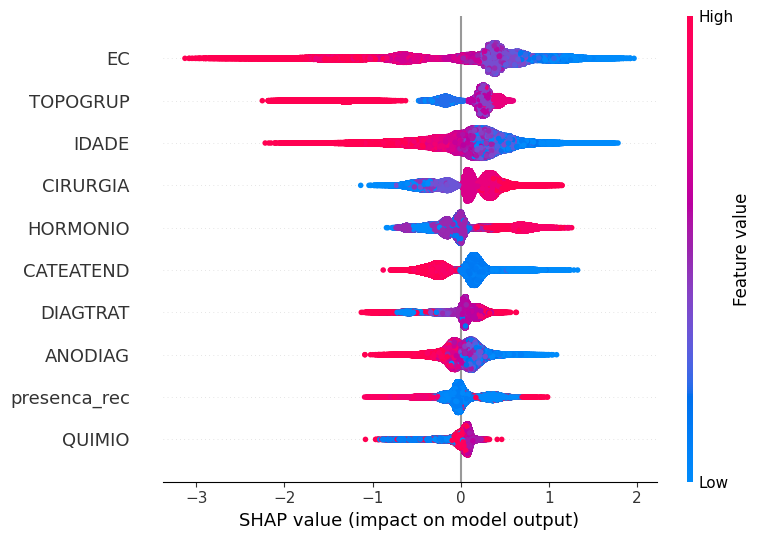

In [36]:
# Importância das features pelos valores SHAP
plot_shap_values(best, X_train, feat_cols)

In [ ]:
dfs = [colo_utero_teste, colo_teste, mama_teste, pele_teste, prost_teste, pulm_teste]

for df in dfs:
    df['TOPOGRUP'] = oe.transform(df[['TOPOGRUP']])
    df['TOPOGRUP'] = ss.transform(df[['TOPOGRUP']])

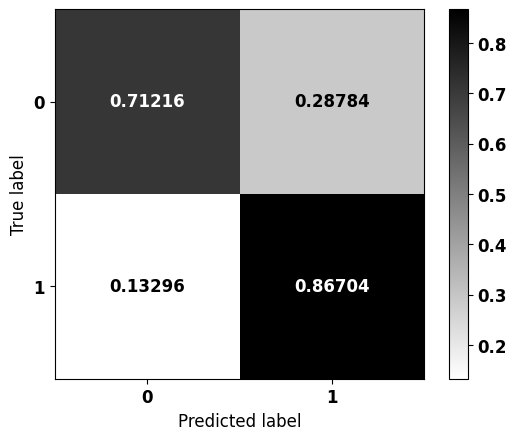


              precision    recall  f1-score   support

           0    0.56973   0.71216   0.63303      5180
           1    0.92415   0.86704   0.89468     20953

    accuracy                        0.83634     26133
   macro avg    0.74694   0.78960   0.76386     26133
weighted avg    0.85390   0.83634   0.84282     26133



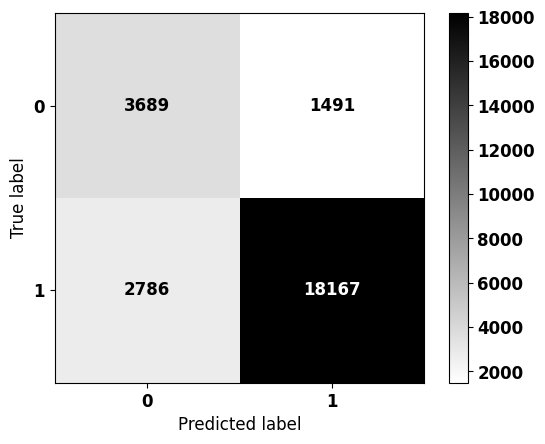


              precision    recall  f1-score   support

           0    0.56973   0.71216   0.63303      5180
           1    0.92415   0.86704   0.89468     20953

    accuracy                        0.83634     26133
   macro avg    0.74694   0.78960   0.76386     26133
weighted avg    0.85390   0.83634   0.84282     26133



In [38]:
# Mama
X_test_mama = mama_teste.drop(columns=list_drop).copy()
y_test_mama = mama_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_mama, y_test_mama)
plot_confusion_matrix(best, X_test_mama, y_test_mama, norm=False)

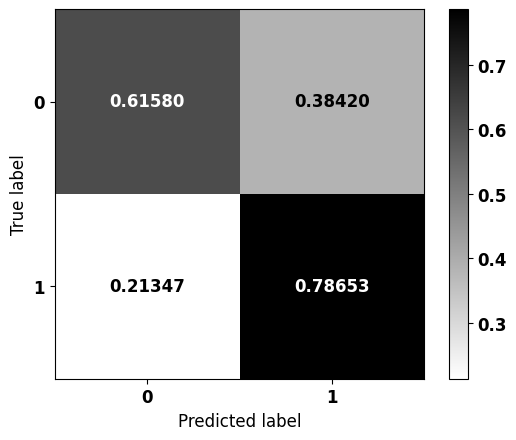


              precision    recall  f1-score   support

           0    0.46274   0.61580   0.52841      5799
           1    0.87271   0.78653   0.82738     19422

    accuracy                        0.74727     25221
   macro avg    0.66773   0.70116   0.67790     25221
weighted avg    0.77845   0.74727   0.75864     25221



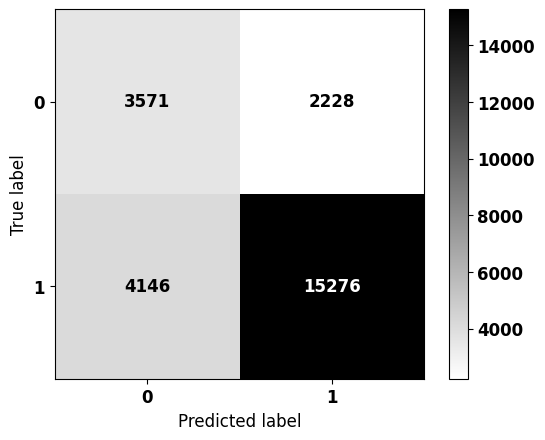


              precision    recall  f1-score   support

           0    0.46274   0.61580   0.52841      5799
           1    0.87271   0.78653   0.82738     19422

    accuracy                        0.74727     25221
   macro avg    0.66773   0.70116   0.67790     25221
weighted avg    0.77845   0.74727   0.75864     25221



In [39]:
# Pele
X_test_pele = pele_teste.drop(columns=list_drop).copy()
y_test_pele = pele_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_pele, y_test_pele)
plot_confusion_matrix(best, X_test_pele, y_test_pele, norm=False)

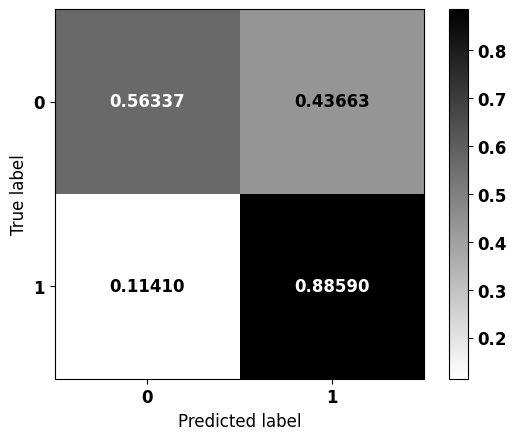


              precision    recall  f1-score   support

           0    0.48742   0.56337   0.52265      3369
           1    0.91331   0.88590   0.89939     17493

    accuracy                        0.83381     20862
   macro avg    0.70036   0.72463   0.71102     20862
weighted avg    0.84453   0.83381   0.83855     20862



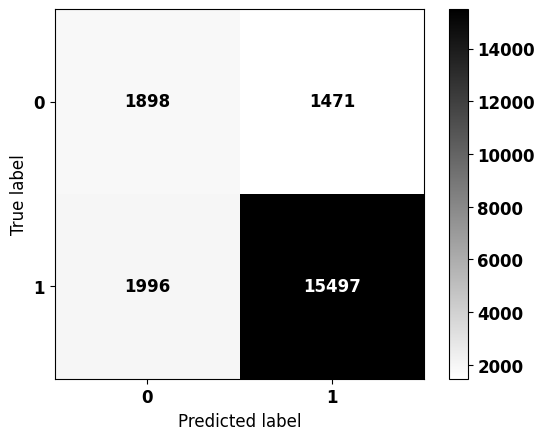


              precision    recall  f1-score   support

           0    0.48742   0.56337   0.52265      3369
           1    0.91331   0.88590   0.89939     17493

    accuracy                        0.83381     20862
   macro avg    0.70036   0.72463   0.71102     20862
weighted avg    0.84453   0.83381   0.83855     20862



In [40]:
# Próstata
X_test_prost = prost_teste.drop(columns=list_drop).copy()
y_test_prost = prost_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_prost, y_test_prost)
plot_confusion_matrix(best, X_test_prost, y_test_prost, norm=False)

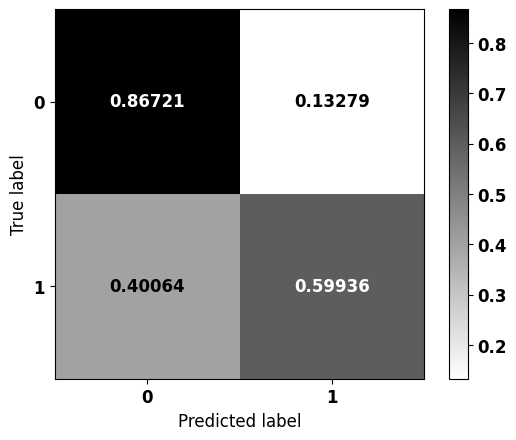


              precision    recall  f1-score   support

           0    0.63648   0.86721   0.73414      6273
           1    0.84802   0.59936   0.70233      7755

    accuracy                        0.71913     14028
   macro avg    0.74225   0.73328   0.71824     14028
weighted avg    0.75342   0.71913   0.71655     14028



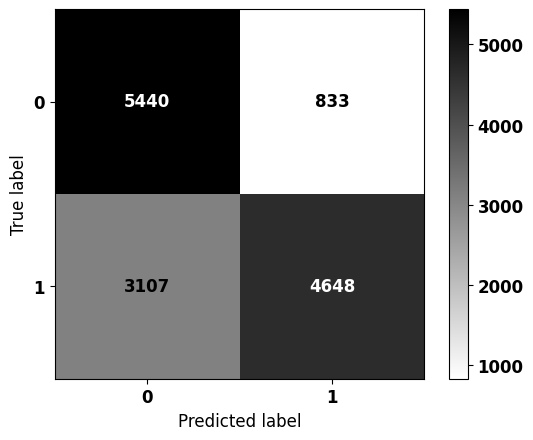


              precision    recall  f1-score   support

           0    0.63648   0.86721   0.73414      6273
           1    0.84802   0.59936   0.70233      7755

    accuracy                        0.71913     14028
   macro avg    0.74225   0.73328   0.71824     14028
weighted avg    0.75342   0.71913   0.71655     14028



In [41]:
# Colorretal
X_test_colo = colo_teste.drop(columns=list_drop).copy()
y_test_colo = colo_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_colo, y_test_colo)
plot_confusion_matrix(best, X_test_colo, y_test_colo, norm=False)

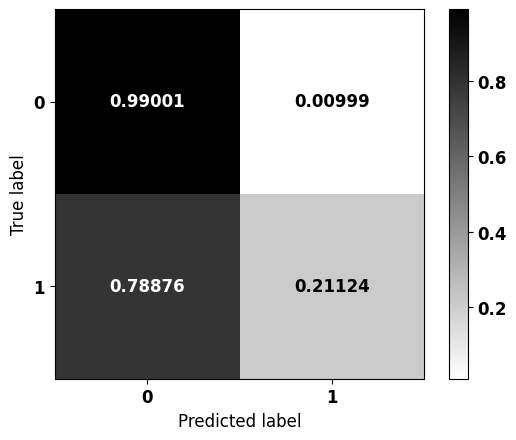


              precision    recall  f1-score   support

           0    0.88977   0.99001   0.93722      8007
           1    0.76676   0.21124   0.33123      1245

    accuracy                        0.88521      9252
   macro avg    0.82827   0.60063   0.63423      9252
weighted avg    0.87322   0.88521   0.85567      9252



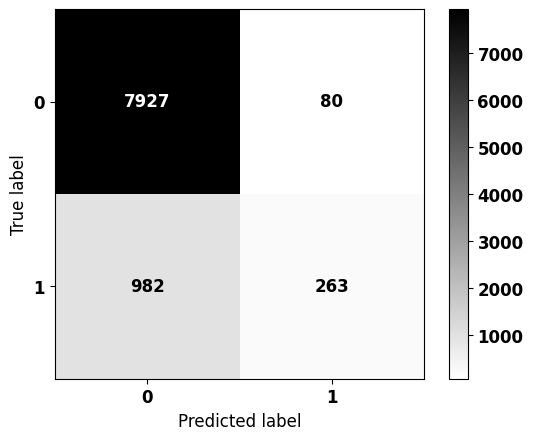


              precision    recall  f1-score   support

           0    0.88977   0.99001   0.93722      8007
           1    0.76676   0.21124   0.33123      1245

    accuracy                        0.88521      9252
   macro avg    0.82827   0.60063   0.63423      9252
weighted avg    0.87322   0.88521   0.85567      9252



In [42]:
# Pulmão
X_test_pulm = pulm_teste.drop(columns=list_drop).copy()
y_test_pulm = pulm_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_pulm, y_test_pulm)
plot_confusion_matrix(best, X_test_pulm, y_test_pulm, norm=False)

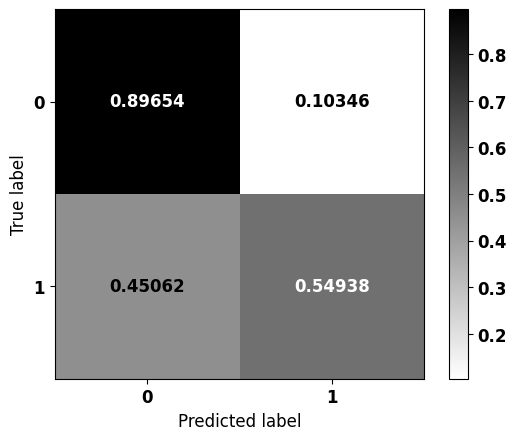


              precision    recall  f1-score   support

           0    0.60046   0.89654   0.71922      2310
           1    0.87546   0.54938   0.67511      3058

    accuracy                        0.69877      5368
   macro avg    0.73796   0.72296   0.69716      5368
weighted avg    0.75712   0.69877   0.69409      5368



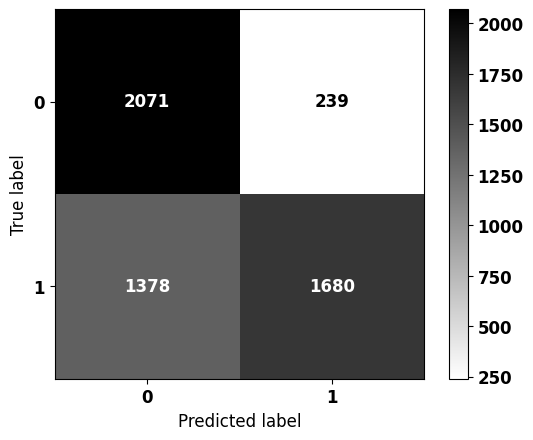


              precision    recall  f1-score   support

           0    0.60046   0.89654   0.71922      2310
           1    0.87546   0.54938   0.67511      3058

    accuracy                        0.69877      5368
   macro avg    0.73796   0.72296   0.69716      5368
weighted avg    0.75712   0.69877   0.69409      5368



In [43]:
# Colo de Útero
X_test_colo_utero = colo_utero_teste.drop(columns=list_drop).copy()
y_test_colo_utero = colo_utero_teste.sobrevida_3anos.copy()

plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero)
plot_confusion_matrix(best, X_test_colo_utero, y_test_colo_utero, norm=False)

## **Voting Classifier**


In [44]:
# Melhores hiperparâmetros do modelo XGBoost
xgb_score = xgb.score(X_test, y_test)
optuna_score = xgb_optuna.score(X_test, y_test)
print(f'Accuracy: XGB = {xgb_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= xgb_score:
    params_xgb = xgb_optuna.get_params()
    print('Otimizado venceu')
else:
    params_xgb = xgb.get_params()
    print('Modelo inicial venceu')

Accuracy: XGB = 0.7921, Optuna = 0.7944

Otimizado venceu


In [45]:
# Melhores hiperparâmetros do modelo LightGBM
lgbm_score = lgbm.score(X_test, y_test)
optuna_score = lgbm_optuna.score(X_test, y_test)
print(f'Accuracy: LGBM = {lgbm_score:.4f}, Optuna = {optuna_score:.4f}\n')

# Comparação entre o modelo inicial e o modelo otimizado
if optuna_score >= lgbm_score:
    params_lgbm = lgbm_optuna.get_params()
    print('Otimizado venceu')
else:
    params_lgbm = lgbm.get_params()
    print('Modelo inicial venceu')

Accuracy: LGBM = 0.7883, Optuna = 0.7923

Otimizado venceu


In [46]:
# Criação dos modelos com os hiperparâmetros de melhor desempenho

# XGBoost
best_xgb = XGBClassifier()
best_xgb.set_params(**params_xgb)

# LightGBM
best_lgbm = LGBMClassifier()
best_lgbm.set_params(**params_lgbm)

LGBMClassifier(class_weight={0: 2.659, 1: 1}, colsample_bytree=0.7,
               learning_rate=0.19, max_depth=9, min_child_weight=7,
               n_estimators=150, random_state=7, verbose=-1)

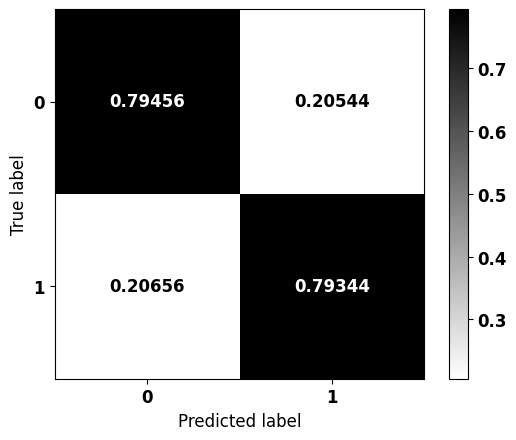


              precision    recall  f1-score   support

           0    0.62989   0.79456   0.70270     30938
           1    0.89722   0.79344   0.84214     69926

    accuracy                        0.79378    100864
   macro avg    0.76355   0.79400   0.77242    100864
weighted avg    0.81522   0.79378   0.79937    100864



In [47]:
from sklearn.ensemble import VotingClassifier

# Criação e treinamento do modelo de votação
clf = VotingClassifier(estimators=[('XGBoost', best_xgb),
                                   ('LightGBM', best_lgbm)
                                   ],
                       voting='soft')

clf.fit(X_train, y_train)

# Matriz de confusão
plot_confusion_matrix(clf, X_test, y_test)

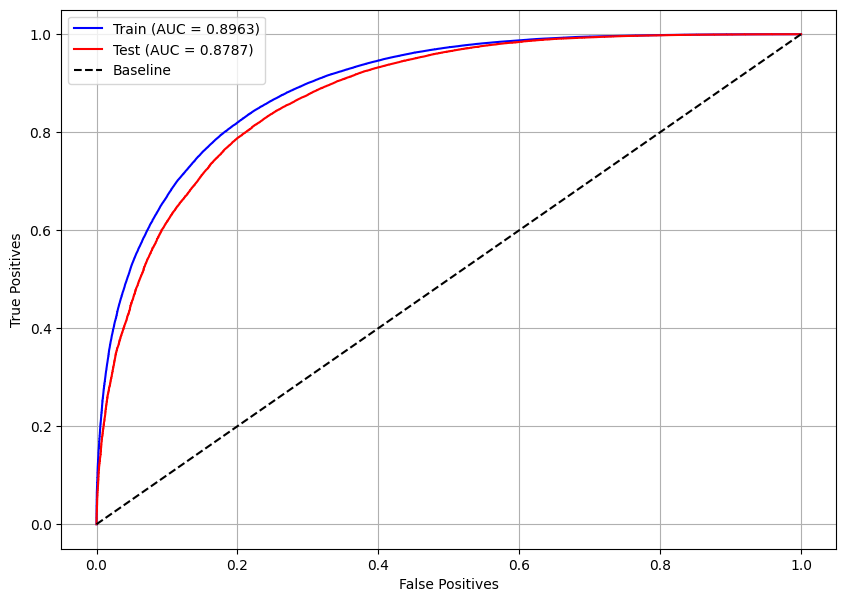

In [48]:
# Curva ROC do melhor modelo de votação
plot_roc_curve(clf, X_train, X_test, y_train, y_test)